In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

Loading Dataset

In [2]:
df = pd.read_csv('E:\\Datamining\\archive\\chinese_mnist.csv')
df

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九
...,...,...,...,...,...
14995,99,5,9,8,八
14996,99,6,9,8,八
14997,99,7,9,8,八
14998,99,8,9,8,八


In [ ]:
bar_data = df['value'].value_counts()

In [ ]:
sns.barplot(bar_data)
plt.xlabel('Character')
plt.ylabel('Number of Images')
plt.xticks(rotation = 90)
plt.show()

In [3]:
def process_image(img_path):
    # Load the image
    img = Image.open(img_path)
    # Convert the image to grayscale (if needed)
    img = img.convert('L')
    # Resize the image to a fixed size (e.g., 64x64)
    img = img.resize((32, 32))
    # Convert image to numpy array
    img_array = np.array(img)
    # Flatten the image to 1D array
    img_flattened = img_array.flatten()
    return img_flattened

In [4]:
images = []
labels = []

for idx, row in df.iterrows():
    img_filename = f"input_{row['suite_id']}_{row['sample_id']}_{row['code']}.jpg"
    img_path = os.path.join('E:\\dataMining\\archive\\data', img_filename)
    img_flattened = process_image(img_path)
    images.append(img_flattened)
    labels.append(row['value'])  #'value' is the label you want to predict

images = np.array(images)
labels = np.array(labels)

In [5]:
images.shape

(15000, 1024)

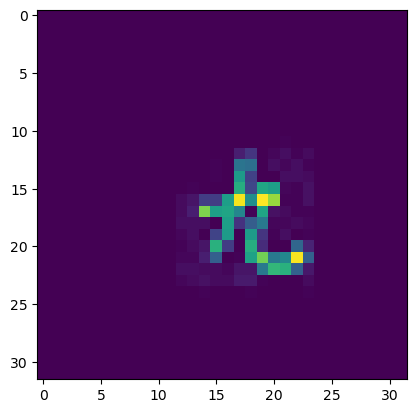

In [6]:
plt.imshow(images[700].reshape(32,32))

In [7]:
labels[700]

9

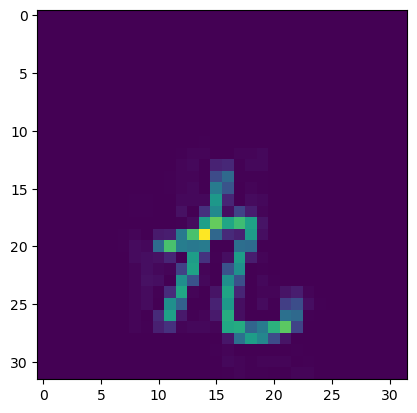

In [8]:
plt.imshow(images[0].reshape(32,32))

In [5]:
images = images / 255.0

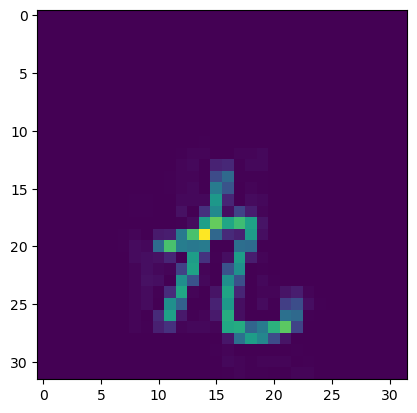

In [10]:
plt.imshow(images[0].reshape(32,32))

In [6]:
# Combine images and labels to shuffle them together
combined = list(zip(images, labels))
np.random.shuffle(combined)
images[:], labels[:] = zip(*combined)

In [7]:
# Define the split ratio
split_ratio = 0.8
split_index = int(len(images) * split_ratio)

# Split the images and labels into training and testing sets
X_train = images[:split_index]
X_test = images[split_index:]
y_train = labels[:split_index]
y_test = labels[split_index:]

In [8]:
X_train = X_train.T
X_test = X_test.T

In [ ]:
def init_params(input_size, hidden_layer_size, output_size):
    W1 = np.random.uniform(-0.5, 0.5, (hidden_layer_size, input_size)) 
    W2 = np.random.uniform(-0.5, 0.5, (output_size, hidden_layer_size))
    b1 = np.random.uniform(-0.5, 0.5, (hidden_layer_size, 1))          
    b2 = np.random.uniform(-0.5, 0.5, (output_size, 1))     

    return W1, b1, W2, b2

In [ ]:
def xavier_params(input_size, hidden_layer_size, output_size):
    np.random.seed(42)
    
    W1 = np.random.randn(hidden_layer_size, input_size) * np.sqrt(2 / (hidden_layer_size + input_size))
    b1 = np.zeros((hidden_layer_size, 1))
    
    W2 = np.random.randn(output_size, hidden_layer_size) * np.sqrt(2 / (output_size + hidden_layer_size))
    b2 = np.zeros((output_size, 1))
    
    return W1, b1, W2, b2

In [ ]:
def kaiming_params(input_size, hidden_layer_size, output_size):
    np.random.seed(42)
    
    W1 = np.random.randn(hidden_layer_size, input_size) * np.sqrt(2 / input_size)
    b1 = np.zeros((hidden_layer_size, 1))
    
    W2 = np.random.randn(output_size, hidden_layer_size) * np.sqrt(2 / hidden_layer_size)
    b2 = np.zeros((output_size, 1))
    
    return W1, b1, W2, b2

In [17]:
def ReLU(z):
    return np.maximum(z,0)

In [18]:
def d_ReLU(z):
    l1 = []
    for i in z:
        if i >= 0:
            l1.append(1) 
        else:
            l1.append(0)
    return np.array(l1)

In [21]:
def softmax(z):
    return np.exp(z)/sum(np.exp(z))

In [ ]:
def forward_prop(X, W1, b1, W2, b2):
    Z1 = np.dot(W1, X) + b1 
    A1 = ReLU(Z1)

    Z2 = np.dot(W2, A1) + b2 
    A2 = softmax(Z2)
    
    return Z1, A1, Z2, A2 

In [9]:
def one_hot(x):
    categories, inverse = np.unique(x, return_inverse=True)
    one = np.zeros((x.size,categories.size), dtype = int)
    one[np.arange(x.size), inverse] = 1
    return one

In [ ]:
def cross_entropy_loss(y_true, y_pred):
    # Clip predictions to avoid log(0) errors
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    # Compute the loss
    loss = -np.sum(y_true * np.log(y_pred)) / y_true.shape[1]
    return loss

In [ ]:
def backpropagation(X, y_true, W1, b1, W2, b2, learning_rate):
    
    # Forward pass
    Z1, A1, _, A2 = forward_prop(X, W1, b1, W2, b2)
    # Compute loss
    #loss = cross_entropy_loss(y_true, A2)
    
    # Backward pass
    m = X.shape[1]  # Number of examples
    
    # Compute gradients
    dZ2 = A2 - y_true.T
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m
    
    #dA1 = np.dot(W2.T, dZ2)
    #dZ1 = dA1 * d_ReLU(Z1) #w2.Tdotdz2 elementwise relu(z1)
    dZ1 = np.dot(W2.T, dZ2) * ReLU(Z1)
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m
    
    # Update weights and biases
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    
    return W1, b1, W2, b2

In [ ]:
def train(X_train, y_train, input_size, hidden_layer_size, output_size, epochs, learning_rate):
    # Initialize parameters
    W1, b1, W2, b2 = kaiming_params(input_size, hidden_layer_size, output_size)
    
    for epoch in range(epochs):
        # Perform backpropagation and update parameters
        W1, b1, W2, b2 = backpropagation(X_train, y_train, W1, b1, W2, b2, learning_rate)
        
        # Print loss every 100 epochs
        print(evaluate(X_train, y_train, W1, b1, W2, b2))
        print(f'Epoch {epoch}')
                
    
    return W1, b1, W2, b2

In [ ]:
def evaluate(X_test, y_test, W1, b1, W2, b2):
    
    # Forward pass
    _, _, _, A2 = forward_prop(X_test, W1, b1, W2, b2)
    
    # Predictions
    predictions = np.argmax(A2, axis=0)
    true_labels = np.argmax(y_test.T, axis=0)
    #np.sum(predictions == Y) / Y.size
    # Compute accuracy
    accuracy = np.mean(predictions == true_labels)
    return accuracy

In [ ]:
# Define hyperparameters            
input_size = 64 * 64          # Size of each image (64x64 flattened)
hidden_layer_size = 128       # Number of neurons in the hidden layer
output_size = 15              # Number of output classes
epochs = 100              # Number of epochs for training
learning_rate = 0.01          # Learning rate

In [10]:
y_train = one_hot(y_train)
y_label = y_test
y_test = one_hot(y_test)

In [22]:
y_train.shape

(12000, 15)

In [ ]:
W1, b1, W2, b2 = train(X_train, y_train, input_size, hidden_layer_size, output_size, epochs, learning_rate)

In [11]:
def xavier_initialization(input_size, num_hidden_layers, initial_hidden_layer_size, output_size):

    params = {}
    layer_sizes = [input_size]

    # Calculate the size of each hidden layer
    for i in range(num_hidden_layers):
        hidden_layer_size = initial_hidden_layer_size // (2 ** i)
        layer_sizes.append(hidden_layer_size)

    layer_sizes.append(output_size)

    # Initialize weights and biases
    for i in range(len(layer_sizes) - 1):
        n_l = layer_sizes[i + 1]
        n_l_prev = layer_sizes[i]
        # Xavier initialization for weights
        params[f'W{i+1}'] = np.random.randn(n_l, n_l_prev) * np.sqrt(1 / n_l_prev)
        # Biases initialized to zeros
        params[f'b{i+1}'] = np.zeros((n_l, 1))

    return params


In [12]:
def kaiming_initialization(input_size, num_hidden_layers, initial_hidden_layer_size, output_size):
    
    params = {}
    layer_sizes = [input_size]

    # Calculate the size of each hidden layer
    for i in range(num_hidden_layers):
        hidden_layer_size = initial_hidden_layer_size // (2 ** i)
        layer_sizes.append(hidden_layer_size)

    layer_sizes.append(output_size)

    # Initialize weights and biases
    for i in range(len(layer_sizes) - 1):
        n_l = layer_sizes[i + 1]
        n_l_prev = layer_sizes[i]
        # Kaiming initialization for weights
        params[f'W{i+1}'] = np.random.randn(n_l, n_l_prev) * np.sqrt(2 / n_l_prev)
        # Biases initialized to zeros
        params[f'b{i+1}'] = np.zeros((n_l, 1))

    return params


In [25]:
def dSoftmax(vector):
    vector = np.array(vector)
    s = softmax(vector)
    return s * (1 - s)

In [13]:
def ReLU2(Z):
    return np.maximum(0, Z)

def d_ReLU2(Z):
    return np.where(Z > 0, 1, 0)

In [27]:
def evaluate2(X, y_true, params):
    caches = forward_prop2(X, params)
    A_last = caches[f'A{len(params)//2}']
    predictions = np.argmax(A_last, axis=0)
    accuracy = np.mean(predictions == np.argmax(y_true, axis=1))
    return accuracy

In [28]:
def evaluate_test_data(X_test, y_test, params):
    # Forward propagation on test data
    caches = forward_prop2(X_test, params)
    
    # Extract the final activation from caches
    A_test = caches[f'A{len(params) // 2}']
    
    # Convert A_test to predictions
    predictions = np.argmax(A_test, axis=0)
    
    # Ensure y_test is a 1D array
    y_test = np.squeeze(y_test)
    
    # Calculate accuracy
    accuracy = np.mean(predictions == y_test) * 100
    
    return accuracy


In [ ]:
def forward_prop2(X, params):
    caches = {}
    A = X
    caches['A0'] = A  # Store the input data
    
    num_layers = len(params) // 2  # Number of layers (excluding input layer)
    
    for i in range(1, num_layers):
        W = params[f'W{i}'].astype(np.float32)
        b = params[f'b{i}'].astype(np.float32)
        Z = np.dot(W, A) + b
        A = ReLU2(Z)
        caches[f'Z{i}'] = Z
        caches[f'A{i}'] = A
    
    # Output layer
    W = params[f'W{num_layers}']
    b = params[f'b{num_layers}']
    Z = np.dot(W, A) + b
    A = softmax(Z)
    caches[f'Z{num_layers}'] = Z
    caches[f'A{num_layers}'] = A
    
    return caches

In [ ]:
def backpropagation2(X, y_true, params, learning_rate):
    caches = forward_prop2(X, params)
    grads = {}
    num_layers = len(params) // 2
    
    # Compute gradients for output layer
    A_last = caches[f'A{num_layers}']
    Z_last = caches[f'Z{num_layers}']
    dZ = A_last - y_true.T
    grads[f'dW{num_layers}'] = np.dot(dZ, caches[f'A{num_layers-1}'].T) / X.shape[1]
    grads[f'db{num_layers}'] = np.sum(dZ, axis=1, keepdims=True) / X.shape[1]
    
    # Backpropagate through hidden layers
    for i in reversed(range(1, num_layers)):
        dA = np.dot(params[f'W{i+1}'].T, dZ)
        dZ = dA * d_ReLU2(caches[f'Z{i}'])
        grads[f'dW{i}'] = np.dot(dZ, caches[f'A{i-1}'].T) / X.shape[1]
        grads[f'db{i}'] = np.sum(dZ, axis=1, keepdims=True) / X.shape[1]
        dZ = dA
    
    # Update parameters
    for i in range(1, num_layers + 1):
        params[f'W{i}'] -= learning_rate * grads[f'dW{i}']
        params[f'b{i}'] -= learning_rate * grads[f'db{i}']
    
    return params


In [ ]:
def train2(X_train, y_train, input_size, num_hidden_layers, initial_hidden_layer_size, output_size, epochs, learning_rate):
    # Initialize parameters
    params = xavier_initialization(input_size, num_hidden_layers, initial_hidden_layer_size, output_size)
    acc = []
    
    for epoch in range(epochs):
        # Perform backpropagation and update parameters
        params = backpropagation2(X_train, y_train, params, learning_rate)
        acc.append(evaluate2(X_train, y_train, params))
        
        # Print accuracy every 5 epochs
        if epoch % 5 == 0:
            print(f'Accuracy at iteration {epoch}: {acc[-1]}')
    
    return params, acc


In [ ]:
input_size = 32*32  # Flattened input size
num_hidden_layers = 3  # Number of hidden layers
initial_hidden_layer_size = 512  # Initial number of neurons in the first hidden layer
output_size = 15  # Output size
epochs = 1000  # Number of training epochs
learning_rate = 0.01  # Learning rate

params, acc = train2(X_train, y_train, input_size, num_hidden_layers, initial_hidden_layer_size, output_size, epochs, learning_rate)

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.show()

In [ ]:
accuracy = evaluate_test_data(X_test, y_test.T, kaiming_initialization(input_size, num_hidden_layers, initial_hidden_layer_size, output_size))

In [ ]:
accuracy

In [ ]:
y_test.shape

In [ ]:
def plot_image_with_prediction(X_test, y_test, params, num_samples=5):
    
    # Forward propagation on test data
    caches = forward_prop2(X_test, params)
    
    # Extract the final activation from caches
    A_test = caches[f'A{len(params) // 2}']
    
    # Convert A_test to predictions
    predictions = np.argmax(A_test, axis=0)
    
    # Randomly select samples to plot
    indices = np.random.choice(X_test.shape[1], num_samples, replace=False)
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5), tight_layout=True)
    
    for i, index in enumerate(indices):
        # Get image and true label
        image = X_test[:, index].reshape(32, 32)  # Adjust image size here
        true_label = y_test[index]
        
        # Get predicted label
        predicted_label = predictions[index]
        
        # Plot the image
        ax = axes[i]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"True: {true_label}\nPred: {predicted_label}")
        ax.axis('off')
    
    plt.show()

In [ ]:
plot_image_with_prediction(X_test, y_label, params, num_samples=5)

In [24]:
def tanh(Z):
    Z = np.array(Z)
    return np.tanh(Z)

def d_tanh(Z):
    Z = np.array(Z)
    return 1 - np.tanh(Z)**2

In [23]:
def sigmoid(Z):
    Z = np.array(Z)
    return 1 / (1 + np.exp(-Z))

def d_sigmoid(Z):
    Z = np.array(Z)
    s = sigmoid(Z)
    return s * (1 - s)

In [31]:
def forward_prop3(X, params, activation='tanh'):
    caches = {}
    A = X
    caches['A0'] = A  # Store the input data
    
    num_layers = len(params) // 2  # Number of layers (excluding input layer)
    
    for i in range(1, num_layers):
        W = params[f'W{i}'].astype(np.float32)
        b = params[f'b{i}'].astype(np.float32)
        Z = np.dot(W, A) + b
        
        if activation == 'tanh':
            A = tanh(Z)
        elif activation == 'sigmoid':
            A = sigmoid(Z)
        else:
            raise ValueError("Unsupported activation function")
        
        caches[f'Z{i}'] = Z
        caches[f'A{i}'] = A
    
    # Output layer
    W = params[f'W{num_layers}']
    b = params[f'b{num_layers}']
    Z = np.dot(W, A) + b
    A = softmax(Z)
    caches[f'Z{num_layers}'] = Z
    caches[f'A{num_layers}'] = A
    
    return caches


In [32]:
def backpropagation3(X, y_true, params, learning_rate, activation='tanh'):
    caches = forward_prop3(X, params, activation)
    grads = {}
    num_layers = len(params) // 2
    m = X.shape[1]
    
    # Output layer gradient
    dZ = caches[f'A{num_layers}'] - y_true.T
    grads[f'dW{num_layers}'] = (1 / m) * np.dot(dZ, caches[f'A{num_layers - 1}'].T)
    grads[f'db{num_layers}'] = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
    
    # Gradients for hidden layers
    for l in range(num_layers - 1, 0, -1):
        dA = np.dot(params[f'W{l+1}'].T, dZ)
        if activation == 'tanh':
            dZ = dA * d_tanh(caches[f'Z{l}'])
        elif activation == 'sigmoid':
            dZ = dA * d_sigmoid(caches[f'Z{l}'])
        else:
            raise ValueError("Unsupported activation function")
        
        grads[f'dW{l}'] = (1 / m) * np.dot(dZ, caches[f'A{l-1}'].T)
        grads[f'db{l}'] = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
    
    # Update parameters
    for l in range(1, num_layers + 1):
        params[f'W{l}'] -= learning_rate * grads[f'dW{l}']
        params[f'b{l}'] -= learning_rate * grads[f'db{l}']
    
    return params


In [42]:
def evaluate3(X, y_true, params, activation):
    caches = forward_prop3(X, params, activation)
    A_last = caches[f'A{len(params)//2}']
    predictions = np.argmax(A_last, axis=0)
    accuracy = np.mean(predictions == np.argmax(y_true, axis=1))
    return accuracy

In [44]:
def train3(X_train, y_train, input_size, num_hidden_layers, initial_hidden_layer_size, output_size, epochs, learning_rate, activation='tanh'):
    params = xavier_initialization(input_size, num_hidden_layers, initial_hidden_layer_size, output_size)

    # Initialize lists to keep track of loss and accuracy
    accuracies = []

    for epoch in range(epochs):
        # Perform forward and backward propagation
        caches = forward_prop3(X_train, params, activation)
        params = backpropagation3(X_train, y_train, params, learning_rate, activation)
        
        # Compute loss and accuracy
        accuracy = evaluate3(X_train, y_train, params, activation)
        accuracies.append(accuracy)
        
        if epoch % 5 == 0:
            print(f'Epoch {epoch}: Accuracy = {accuracy}')

    return params, accuracies


In [49]:
# Set your parameters
input_size = 32*32  # Size of the input layer (adjust as needed)
num_hidden_layers = 3  # Number of hidden layers
initial_hidden_layer_size = 512  # Size of the first hidden layer
output_size = 15  # Number of classes
epochs = 1000  # Number of epochs for training
learning_rate = 0.01  # Learning rate

# Choose the activation function ('tanh' or 'sigmoid')
activation_function = 'tanh'

# Train the neural network
params, accuracies = train3(X_train, y_train, input_size, num_hidden_layers, initial_hidden_layer_size, output_size, epochs, learning_rate, activation=activation_function)


Epoch 0: Accuracy = 0.07333333333333333
Epoch 5: Accuracy = 0.07408333333333333
Epoch 10: Accuracy = 0.0745
Epoch 15: Accuracy = 0.07508333333333334
Epoch 20: Accuracy = 0.07541666666666667
Epoch 25: Accuracy = 0.07625
Epoch 30: Accuracy = 0.07683333333333334
Epoch 35: Accuracy = 0.07766666666666666
Epoch 40: Accuracy = 0.07775
Epoch 45: Accuracy = 0.07883333333333334
Epoch 50: Accuracy = 0.07941666666666666
Epoch 55: Accuracy = 0.08025
Epoch 60: Accuracy = 0.082
Epoch 65: Accuracy = 0.08366666666666667
Epoch 70: Accuracy = 0.08475
Epoch 75: Accuracy = 0.08533333333333333
Epoch 80: Accuracy = 0.08666666666666667
Epoch 85: Accuracy = 0.08675
Epoch 90: Accuracy = 0.08808333333333333
Epoch 95: Accuracy = 0.08925
Epoch 100: Accuracy = 0.09066666666666667
Epoch 105: Accuracy = 0.092
Epoch 110: Accuracy = 0.09225
Epoch 115: Accuracy = 0.09316666666666666
Epoch 120: Accuracy = 0.09433333333333334
Epoch 125: Accuracy = 0.09525
Epoch 130: Accuracy = 0.09691666666666666
Epoch 135: Accuracy = 0.0

In [ ]:

# Evaluate the model on test data
test_accuracy = evaluate_test_data(X_test, y_test, params, activation=activation_function)
print(f"Test Accuracy: {test_accuracy}%")

In [ ]:
y_train.shape

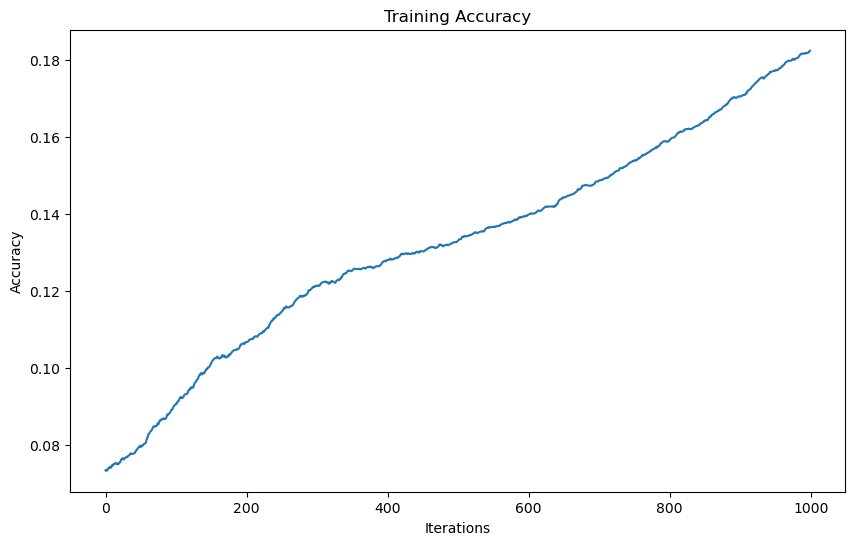

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(accuracies)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.show()

In [14]:
def forward_prop_drop(X, params, keep_prob=1.0, activation='sigmoid', train=True):
    caches = {}
    A = X
    caches['A0'] = A  # Store the input data
    
    num_layers = len(params) // 2  # Number of layers (excluding input layer)
    
    for i in range(1, num_layers):
        W = params[f'W{i}'].astype(np.float32)
        b = params[f'b{i}'].astype(np.float32)
        Z = np.dot(W, A) + b
        
        if activation == 'sigmoid':
            A = sigmoid(Z)
        elif activation == 'tanh':
            A = tanh(Z)
        elif activation == 'relu':
            A = ReLU2(Z)
        
        if train:
            D = np.random.rand(A.shape[0], A.shape[1]) < keep_prob
            A = A * D
            A = A / keep_prob
            caches[f'D{i}'] = D
        
        caches[f'Z{i}'] = Z
        caches[f'A{i}'] = A
    
    # Output layer
    W = params[f'W{num_layers}']
    b = params[f'b{num_layers}']
    Z = np.dot(W, A) + b
    A = softmax(Z)
    caches[f'Z{num_layers}'] = Z
    caches[f'A{num_layers}'] = A
    
    return caches


In [17]:
def backpropagation_drop(X, y_true, params, learning_rate, keep_prob=1.0, activation='sigmoid'):
    caches = forward_prop_drop(X, params, keep_prob=keep_prob, activation=activation, train=True)
    grads = {}
    num_layers = len(params) // 2
    m = X.shape[1]
    
    # Output layer gradients
    A_last = caches[f'A{num_layers}']
    dZ_last = A_last - y_true.T
    grads[f'dW{num_layers}'] = np.dot(dZ_last, caches[f'A{num_layers-1}'].T) / m
    grads[f'db{num_layers}'] = np.sum(dZ_last, axis=1, keepdims=True) / m
    
    for i in reversed(range(1, num_layers)):
        dA = np.dot(params[f'W{i+1}'].T, dZ_last)
        if keep_prob < 1.0:
            D = caches[f'D{i}']
            dA = dA * D
            dA = dA / keep_prob
        
        Z = caches[f'Z{i}']
        if activation == 'sigmoid':
            dZ = dA * d_sigmoid(Z)
        elif activation == 'tanh':
            dZ = dA * d_tanh(Z)
        elif activation == 'relu':
            dZ = dA * d_ReLU2(Z)
        
        grads[f'dW{i}'] = np.dot(dZ, caches[f'A{i-1}'].T) / m
        grads[f'db{i}'] = np.sum(dZ, axis=1, keepdims=True) / m
        dZ_last = dZ
    
    for i in range(1, num_layers + 1):
        params[f'W{i}'] -= learning_rate * grads[f'dW{i}']
        params[f'b{i}'] -= learning_rate * grads[f'db{i}']
    
    return params


In [29]:
def evaluate_drop(X, y_true, params, activation):
    caches = forward_prop_drop(X, params,keep_prob=0.7, activation=activation,  train=True)
    A_last = caches[f'A{len(params)//2}']
    predictions = np.argmax(A_last, axis=0)
    accuracy = np.mean(predictions == np.argmax(y_true, axis=1))
    return accuracy

In [31]:
def train_drop(X_train, y_train, input_size, num_hidden_layers, initial_hidden_layer_size, output_size, epochs, learning_rate, keep_prob=1.0, activation='sigmoid'):
    params = kaiming_initialization(input_size, num_hidden_layers, initial_hidden_layer_size, output_size)
    accuracies = []

    for epoch in range(epochs):
        # Perform backpropagation and update parameters
        params = backpropagation_drop(X_train, y_train, params, learning_rate, keep_prob=keep_prob, activation=activation)
        
        # Calculate accuracy on training data
        accuracy = evaluate_drop(X_train, y_train, params, activation=activation)
        accuracies.append(accuracy)

        # Optionally, calculate and store the loss (if needed)
        if epoch % 5 == 0:
            print(f'Epoch {epoch}: Accuracy = {accuracy}')
    
    return params, accuracies


In [32]:
# Set your parameters
input_size = 32*32  # Size of the input layer (adjust as needed)
num_hidden_layers = 3  # Number of hidden layers
initial_hidden_layer_size = 512  # Size of the first hidden layer
output_size = 15  # Number of classes
epochs = 1000  # Number of epochs for training
learning_rate = 0.01  # Learning rate
keep_prob = 0.7

# Choose the activation function ('tanh' or 'sigmoid')
activation_function = 'relu'

# Train the neural network
params, accuracies = train_drop(X_train, y_train, input_size, num_hidden_layers, initial_hidden_layer_size, output_size, epochs, learning_rate,keep_prob=keep_prob, activation=activation_function)


Epoch 0: Accuracy = 0.07025
Epoch 5: Accuracy = 0.07083333333333333
Epoch 10: Accuracy = 0.06916666666666667
Epoch 15: Accuracy = 0.06816666666666667
Epoch 20: Accuracy = 0.07325
Epoch 25: Accuracy = 0.07108333333333333
Epoch 30: Accuracy = 0.06758333333333333
Epoch 35: Accuracy = 0.06691666666666667
Epoch 40: Accuracy = 0.06833333333333333
Epoch 45: Accuracy = 0.07075
Epoch 50: Accuracy = 0.06716666666666667
Epoch 55: Accuracy = 0.06925
Epoch 60: Accuracy = 0.07425
Epoch 65: Accuracy = 0.07233333333333333
Epoch 70: Accuracy = 0.07141666666666667
Epoch 75: Accuracy = 0.06875
Epoch 80: Accuracy = 0.07391666666666667
Epoch 85: Accuracy = 0.07225
Epoch 90: Accuracy = 0.07208333333333333
Epoch 95: Accuracy = 0.07058333333333333
Epoch 100: Accuracy = 0.07425
Epoch 105: Accuracy = 0.06808333333333333
Epoch 110: Accuracy = 0.073
Epoch 115: Accuracy = 0.07508333333333334
Epoch 120: Accuracy = 0.07383333333333333
Epoch 125: Accuracy = 0.07375
Epoch 130: Accuracy = 0.07408333333333333
Epoch 135:

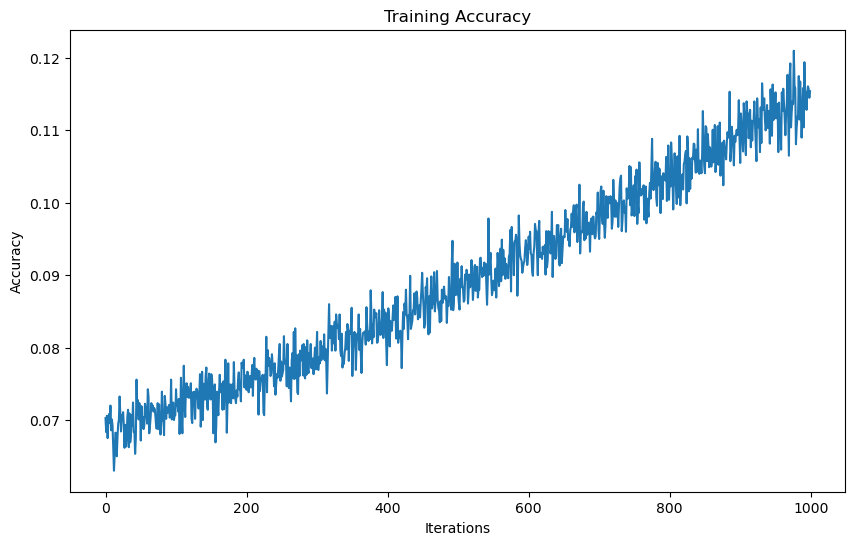

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(accuracies)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.show()